### Import bibliothèque

In [121]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

### Chemin données

In [122]:
PATH = os.getcwd()
PATH_Data = PATH+'/data/Test1'
PATH_Result = PATH+'/data/results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train
PATH_Data:   /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1
PATH_Result: /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/results


### Création SparkSession

Processus de pilotage (driver process)

In [123]:
spark = (SparkSession
             .builder
             .appName('test1-spark')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

#### SparkContext

In [124]:
sc = spark.sparkContext

In [125]:
spark

### Import données

Chargement des images au format binaire <br>
Chargement de toutes les données dans les sous-dossier du chemin de données

In [126]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [127]:
images.show(1, truncate=False)

+------------------------------------------------------------------------------------------------------------------------+-------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

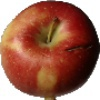

In [128]:
binary_image = images.select("content").take(1)[0].content
image = Image.open(io.BytesIO(binary_image))
image

Affichage des 5 premières images

In [129]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
# Création d'une vue temporaire
images.createOrReplaceTempView("images_view")
# Rafraîchissement de la table
spark.sql("REFRESH TABLE images_view")
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------------------------------------------------------------------------+--------------+
|path                                                                                                                    |label         |
+------------------------------------------------------------------------------------------------------------------------+--------------+
|file:/home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1/Apple Braeburn/r_140_100.jpg|Apple Braeburn|
|file:/home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1/Apple Braeburn/r_163_100.jpg|Apple Braeburn|
|file:/home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1/Apple B

### Chargement du modèle

In [130]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

### Suppression de la dernière couche du modèle <br>
Cette couche sert à classer les images selon 1000 catégorie, ce n'est pas l'objectif ici.

In [131]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [132]:
# test poids du modèle
weights = new_model.get_weights()
print(f"Distribution des poids avec le broadcast :{[w.shape for w in weights]}")

Distribution des poids avec le broadcast :[(3, 3, 3, 32), (32,), (32,), (32,), (32,), (3, 3, 32, 1), (32,), (32,), (32,), (32,), (1, 1, 32, 16), (16,), (16,), (16,), (16,), (1, 1, 16, 96), (96,), (96,), (96,), (96,), (3, 3, 96, 1), (96,), (96,), (96,), (96,), (1, 1, 96, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 64), (64,), (64,), 

### Résumé du modèle

In [133]:
new_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Distribution des poids du modèle sur les différents workeurs

In [134]:
brodcast_weights = sc.broadcast(new_model.get_weights())

In [135]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

In [136]:
reconstructed_model = model_fn()
reconstructed_weights = reconstructed_model.get_weights()
print(f"Distribution des poids avec le broadcast :{[w.shape for w in reconstructed_weights]}")

Distribution des poids avec le broadcast :[(3, 3, 3, 32), (32,), (32,), (32,), (32,), (3, 3, 32, 1), (32,), (32,), (32,), (32,), (1, 1, 32, 16), (16,), (16,), (16,), (16,), (1, 1, 16, 96), (96,), (96,), (96,), (96,), (3, 3, 96, 1), (96,), (96,), (96,), (96,), (1, 1, 96, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 64), (64,), (64,), 

for original, reconstructed in zip(weights, reconstructed_weights):
    if not np.array_equal(original, reconstructed):
        print("Weights do not match after reconstruction")
        break
    else:
        print("Match after reconstruction")

In [137]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/anonyme2/anaconda3/envs/cloud-computing/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [138]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [139]:
print(PATH_Result)

/home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/results


In [140]:
features_df.write.mode("overwrite").parquet(PATH_Result)

2024-05-27 10:05:23.398312: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:05:23.411602: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:05:23.480913: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 10:05:25.077564: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-27 10:05:29.873450: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41746432 exceeds 10% of free system memory.
2024-05-27 10:05:29.961481: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41746432 exceeds 10% of fr

In [141]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [142]:
df.head()

,path,label,features
0,file:/home/anonyme2/Documents/Dev/cloud-comput...,Apple Braeburn,"[0.5401419, 0.08820487, 0.0, 0.0, 0.0, 1.51073..."
1,file:/home/anonyme2/Documents/Dev/cloud-comput...,Apple Braeburn,"[0.1799983, 0.009469149, 0.0, 0.0, 0.0, 1.2730..."
2,file:/home/anonyme2/Documents/Dev/cloud-comput...,Apple Braeburn,"[0.0, 0.018066201, 0.0, 0.0, 0.0, 0.45691603, ..."
3,file:/home/anonyme2/Documents/Dev/cloud-comput...,Apple Braeburn,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5070565, 0.0, 0.00..."
4,file:/home/anonyme2/Documents/Dev/cloud-comput...,Apple Braeburn,"[0.0, 0.005024151, 0.0, 0.0, 0.0, 0.29557523, ..."


In [143]:
df.loc[0,'features'].shape

(1280,)

In [146]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import SparkSession

# Définir les chemins
PATH = os.getcwd()
PATH_Data = os.path.join(PATH, 'data', 'Test1')
PATH_Result = os.path.join(PATH, 'data', 'Results')
print(f'PATH:        {PATH}\nPATH_Data:   {PATH_Data}\nPATH_Result: {PATH_Result}')

# Initialisation de Spark
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

sc = spark.sparkContext

# Chargement des images
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
# Création d'une vue temporaire
images.createOrReplaceTempView("images_view")
# Rafraîchissement de la table
spark.sql("REFRESH TABLE images_view")

# Chargement et modification du modèle MobileNetV2
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Vérifiez que les poids sont correctement récupérés
weights = new_model.get_weights()
print(f"Shape of weights before broadcasting: {[w.shape for w in weights]}")

# Diffusion des poids du modèle
broadcast_weights = sc.broadcast(weights)

# Fonction pour reconstruire le modèle avec les poids diffusés
def model_fn():
    model = MobileNetV2(weights=None, include_top=True, input_shape=(224, 224, 3))
    new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

# Fonction de prétraitement des images
def preprocess(content):
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

# Fonction de featurisation
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

# UDF pandas pour featuriser les images
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

# Application de l'UDF pandas pour featuriser les images
features_df = images.repartition(20).select(col("path"), col("label"), featurize_udf("content").alias("features"))

# Collecte des features extraites pour PCA
features_pdf = features_df.select("features").toPandas()
features = np.array(features_pdf["features"].tolist())

# Application de la PCA pour réduire la dimensionnalité
pca = PCA(n_components=0.80)  # Conserver 80% de la variance
reduced_features = pca.fit_transform(features)

# Création d'un DataFrame Spark avec les features réduites
reduced_features_pdf = pd.DataFrame(reduced_features)
reduced_features_df = spark.createDataFrame(reduced_features_pdf)

# Joindre les features réduites avec le DataFrame original
final_df = features_df.select("path", "label").join(reduced_features_df)

# Sauvegarde des résultats
final_df.write.mode("overwrite").parquet(PATH_Result)
df = pd.read_parquet(PATH_Result, engine='pyarrow')

# Afficher les résultats
print(df.head())

PATH:        /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train
PATH_Data:   /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1
PATH_Result: /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Results
Shape of weights before broadcasting: [(3, 3, 3, 32), (32,), (32,), (32,), (32,), (3, 3, 32, 1), (32,), (32,), (32,), (32,), (1, 1, 32, 16), (16,), (16,), (16,), (16,), (1, 1, 16, 96), (96,), (96,), (96,), (96,), (3, 3, 96, 1), (96,), (96,), (96,), (96,), (1, 1, 96, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,

2024-05-27 10:09:41.808166: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:09:41.811953: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 10:09:41.876847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 10:09:43.356515: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-05-27 10:09:47.426232: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41746432 exceeds 10% of free system memory.
2024-05-27 10:09:47.512057: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 41746432 exceeds 10% of fr

                                                path           label  \
0  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
1  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
2  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
3  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
4  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   

           0         1         2         3         4         5         6  \
0 -15.055764 -1.153472  3.958019 -2.012517  1.908185  0.680993 -2.328091   
1 -15.055764 -1.153472  3.958019 -2.012517  1.908185  0.680993 -2.328091   
2 -15.055764 -1.153472  3.958019 -2.012517  1.908185  0.680993 -2.328091   
3 -15.055764 -1.153472  3.958019 -2.012517  1.908185  0.680993 -2.328091   
4 -15.055764 -1.153472  3.958019 -2.012517  1.908185  0.680993 -2.328091   

          7         8         9        10  
0  2.457378 -3.050833 -1.380721 -3.134937  
1  2.457378 -3.050833 

PATH:        /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train
PATH_Data:   /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Test1
PATH_Result: /home/anonyme2/Documents/Dev/cloud-computing/ai-cloud-computing-spark/train/data/Results
Shape of weights before broadcasting: [(3, 3, 3, 32), (32,), (32,), (32,), (32,), (3, 3, 32, 1), (32,), (32,), (32,), (32,), (1, 1, 32, 16), (16,), (16,), (16,), (16,), (1, 1, 16, 96), (96,), (96,), (96,), (96,), (3, 3, 96, 1), (96,), (96,), (96,), (96,), (1, 1, 96, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 24), (24,), (24,), (24,), (24,), (1, 1, 24, 144), (144,), (144,), (144,), (144,), (3, 3, 144, 1), (144,), (144,), (144,), (144,), (1, 1, 144, 32), (32,), (32,), (32,), (32,), (1, 1, 32, 192), (192,), (192,), (192,), (192,), (3, 3, 192, 1), (192,), (192,), (192,), (192,), (1, 1, 192, 32), (32,), (32,

/home/anonyme2/anaconda3/envs/cloud-computing/lib/python3.10/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(
2024-05-27 11:29:14.181189: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 11:29:14.185105: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-27 11:29:14.250457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-27 11:29:15.548052: W tensorflow/compiler/tf2

Nombre de composantes principales pour 80% de la variance: 11


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step0 + 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step0 + 1) / 1]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step + 1) / 20]
1/1 ━━━━━━━━━

                                                path           label  \
0  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
1  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
2  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
3  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   
4  file:/home/anonyme2/Documents/Dev/cloud-comput...  Apple Braeburn   

                                         pcaFeatures  
0  {'type': 1, 'size': None, 'indices': None, 'va...  
1  {'type': 1, 'size': None, 'indices': None, 'va...  
2  {'type': 1, 'size': None, 'indices': None, 'va...  
3  {'type': 1, 'size': None, 'indices': None, 'va...  
4  {'type': 1, 'size': None, 'indices': None, 'va...  


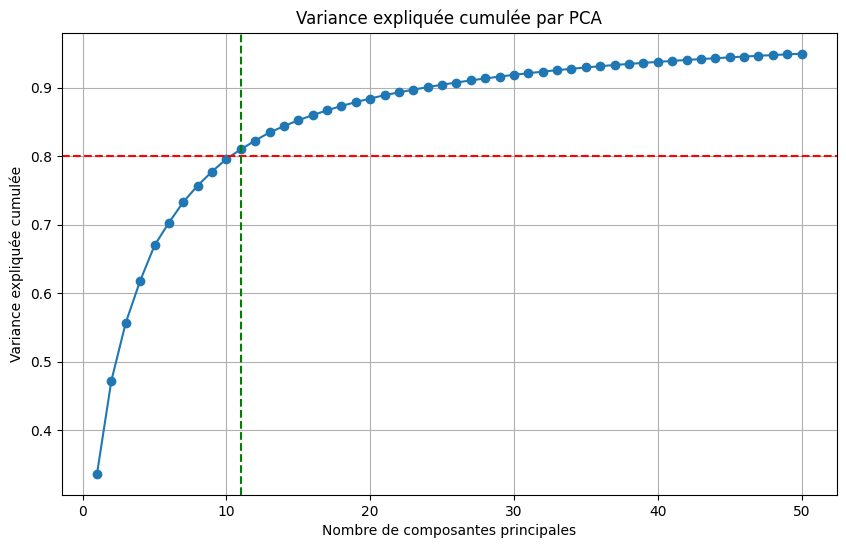

In [150]:
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

# Définir les chemins
PATH = os.getcwd()
PATH_Data = os.path.join(PATH, 'data', 'Test1')
PATH_Result = os.path.join(PATH, 'data', 'Results')
print(f'PATH:        {PATH}\nPATH_Data:   {PATH_Data}\nPATH_Result: {PATH_Result}')

# Initialisation de Spark
spark = (SparkSession
             .builder
             .appName('P8')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .getOrCreate()
)

sc = spark.sparkContext

# Chargement des images
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
# Création d'une vue temporaire
images.createOrReplaceTempView("images_view")
# Rafraîchissement de la table
spark.sql("REFRESH TABLE images_view")

# Chargement et modification du modèle MobileNetV2
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Vérifiez que les poids sont correctement récupérés
weights = new_model.get_weights()
print(f"Shape of weights before broadcasting: {[w.shape for w in weights]}")

# Diffusion des poids du modèle
broadcast_weights = sc.broadcast(weights)

# Fonction pour reconstruire le modèle avec les poids diffusés
def model_fn():
    model = MobileNetV2(weights=None, include_top=True, input_shape=(224, 224, 3))
    new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    new_model.set_weights(broadcast_weights.value)
    return new_model

# Fonction de prétraitement des images
def preprocess(content):
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

# Fonction de featurisation
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    output = [p.flatten() for p in preds]
    return pd.Series(output)

# UDF pandas pour featuriser les images
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

# Application de l'UDF pandas pour featuriser les images
features_df = images.repartition(20).select(col("path"), col("label"), featurize_udf("content").alias("features"))

# Convertir les features en format compatible avec pyspark.ml.linalg.Vectors
def to_vector(features):
    return Vectors.dense(features)

vector_df = features_df.rdd.map(lambda row: Row(path=row.path, label=row.label, features=to_vector(row.features))).toDF()

# Calculer les composantes principales nécessaires pour 80% de la variance
# Faire un premier ajustement de PCA pour déterminer le nombre de composantes nécessaires
pca = PCA(k=50, inputCol="features", outputCol="pcaFeatures")  # Nombre arbitraire initial de composantes
pca_model = pca.fit(vector_df)

# Calculer la variance cumulée
explained_variance = np.cumsum(pca_model.explainedVariance.toArray())
k = np.argmax(explained_variance >= 0.80) + 1  # Trouver le nombre de composantes pour 80% de la variance

print(f"Nombre de composantes principales pour 80% de la variance: {k}")

# Refaire la PCA avec le bon nombre de composantes
pca = PCA(k=k, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(vector_df)

# Transformer les données
pca_result = pca_model.transform(vector_df).select("path", "label", "pcaFeatures")

# Sauvegarde des résultats
pca_result.write.mode("overwrite").parquet(PATH_Result)
df = pd.read_parquet(PATH_Result, engine='pyarrow')

# Afficher les résultats
print(df.head())

# Visualisation de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--')
plt.axvline(x=k, color='g', linestyle='--')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée par PCA')
plt.grid(True)
plt.show()
